Iteration 1000, Current Cost: 3
Iteration 2000, Current Cost: 2
Iteration 3000, Current Cost: 2
Iteration 4000, Current Cost: 2
Iteration 5000, Current Cost: 2
Iteration 6000, Current Cost: 2
Iteration 7000, Current Cost: 2
Iteration 8000, Current Cost: 2
Iteration 9000, Current Cost: 2
Iteration 10000, Current Cost: 2
Iteration 11000, Current Cost: 2
Iteration 12000, Current Cost: 2
Iteration 13000, Current Cost: 2
Iteration 14000, Current Cost: 2
Iteration 15000, Current Cost: 2
Iteration 16000, Current Cost: 2
Iteration 17000, Current Cost: 2
Iteration 18000, Current Cost: 2
Iteration 19000, Current Cost: 2
Iteration 20000, Current Cost: 2
Iteration 21000, Current Cost: 2
Iteration 22000, Current Cost: 2
Iteration 23000, Current Cost: 2
Iteration 24000, Current Cost: 2
Iteration 25000, Current Cost: 2
Iteration 26000, Current Cost: 2
Iteration 27000, Current Cost: 2
Iteration 28000, Current Cost: 2
Iteration 29000, Current Cost: 2
Iteration 30000, Current Cost: 2
Iteration 31000, Cu

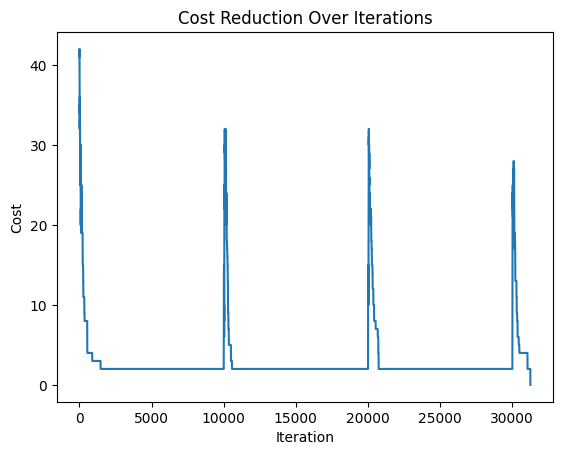

In [2]:
import threading
import tkinter as tk
from tkinter import ttk
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import statistics
import time

#enter any board youd like here in string format:
sudokuorg = """
200600830
908530602
001807040
060053000
704208000
023496000
080060005
000105763
506304000
"""

class MyApp:
    def __init__(self, root):
        self.root = root
        self.root.title("9x9 Grid of Buttons")
        
        self.buttons = []
        self.create_grid()
    
    def create_grid(self):
        for i in range(9):
            row = []
            for j in range(9):
                button = ttk.Button(self.root, text="", command=lambda i=i, j=j: self.on_button_click(i, j))
                button.grid(row=i, column=j, padx=5, pady=5, sticky="nsew")
                row.append(button)
            self.buttons.append(row)
                
        for i in range(9):
            self.root.grid_rowconfigure(i, weight=1)
            self.root.grid_columnconfigure(i, weight=1)
    
    def on_button_click(self, i, j):
        print(f"Button {i},{j} clicked")
    
    def update_grid(self, data):
        lines = data.strip().split("\n")
        for i in range(9):
            for j in range(9):
                self.buttons[i][j].config(text=lines[i][j])

def start_tkinter_app():
    global app
    root = tk.Tk()
    app = MyApp(root)
    root.mainloop()

gui_thread = threading.Thread(target=start_tkinter_app)
gui_thread.start()

def initialStateGen(sudoku_str):
    def get_subgrid_indices(subgrid_number):
        row_start = (subgrid_number // 3) * 3
        col_start = (subgrid_number % 3) * 3
        indices = [(row_start + i) * 9 + (col_start + j) for i in range(3) for j in range(3)]
        return indices

    sudoku = list(sudoku_str.replace('\n', ''))
    
    def fill_subgrid(sudoku, subgrid_number):
        indices = get_subgrid_indices(subgrid_number)
        numbers_present = {int(sudoku[index]) for index in indices if sudoku[index] != '0'}
        missing_numbers = list(set(range(1, 10)) - numbers_present)
        random.shuffle(missing_numbers)
        
        for index in indices:
            if sudoku[index] == '0':
                sudoku[index] = str(missing_numbers.pop())
    
    for subgrid_number in range(9):
        fill_subgrid(sudoku, subgrid_number)
    
    result = ''.join(sudoku)
    return '\n'.join([result[i:i+9] for i in range(0, 81, 9)])

def fixSudokuValues(sudoku_str):
    fixed_sudoku = list(sudoku_str.replace('\n', ''))
    for i in range(len(fixed_sudoku)):
        if fixed_sudoku[i] != '0':
            fixed_sudoku[i] = '1'
        else:
            fixed_sudoku[i] = '0'
    return ''.join(fixed_sudoku)

def nextGen(sudoku_str, fixed_sudoku_str):
    def get_subgrid_indices(subgrid_number):
        row_start = (subgrid_number // 3) * 3
        col_start = (subgrid_number % 3) * 3
        indices = [(row_start + i) * 9 + (col_start + j) for i in range(3) for j in range(3)]
        return indices
    
    sudoku = list(sudoku_str.replace('\n', ''))
    fixed_sudoku = list(fixed_sudoku_str.replace('\n', ''))
    subgrid_number = random.randint(0, 8)
    indices = get_subgrid_indices(subgrid_number)
    
    non_fixed_indices = [idx for idx in indices if fixed_sudoku[idx] == '0']
    
    if len(non_fixed_indices) < 2:
        return '\n'.join([sudoku_str[i:i+9] for i in range(0, 81, 9)])
    
    idx1, idx2 = random.sample(non_fixed_indices, 2)
    sudoku[idx1], sudoku[idx2] = sudoku[idx2], sudoku[idx1]
    
    result = ''.join(sudoku)
    return '\n'.join([result[i:i+9] for i in range(0, 81, 9)])

def calculatingCost(board):
    board = board.replace('\n', '')
    total = 0
    
    for i in range(9):
        row_count = [0] * 10
        col_count = [0] * 10
        for j in range(9):
            row_num = int(board[i * 9 + j])
            col_num = int(board[j * 9 + i])
            if row_num != 0:
                row_count[row_num] += 1
            if col_num != 0:
                col_count[col_num] += 1
        
        total += sum(x - 1 for x in row_count if x > 1)
        total += sum(x - 1 for x in col_count if x > 1)
    
    return total

def simulatedAnnealing(sudoku_str, initial_temp, cooling_rate, max_iterations):
    current_sudoku = initialStateGen(sudoku_str)
    fixed_sudoku = fixSudokuValues(sudoku_str)
    current_cost = calculatingCost(current_sudoku)
    temperature = initial_temp
    
    best_sudoku = current_sudoku
    best_cost = current_cost

    costs = [current_cost]
    iteration = 0
    stuck_count = 0

    while current_cost != 0 and iteration < max_iterations:
        new_sudoku = nextGen(current_sudoku, fixed_sudoku)
        new_cost = calculatingCost(new_sudoku)
        
        cost_diff = new_cost - current_cost
        acceptance_probability = math.exp(-cost_diff / temperature) if cost_diff > 0 else 1

        if random.random() < acceptance_probability:
            current_sudoku = new_sudoku
            current_cost = new_cost

        if current_cost < best_cost:
            best_sudoku = current_sudoku
            best_cost = current_cost
        
        temperature *= cooling_rate
        costs.append(current_cost)
        iteration += 1

        if current_cost >= best_cost:
            stuck_count += 1
        else:
            stuck_count = 0

        if stuck_count > 10000:
            temperature *= 1.1
            stuck_count = 0
            if temperature<0.01:
                temperature+=3.5
                max_iterations*=1.1

        # Update GUI every 1000 iterations
        if iteration % 1000 == 0:
            app.update_grid(current_sudoku)
            print(f"Iteration {iteration}, Current Cost: {current_cost}")

    return best_sudoku, best_cost, costs

# Parameters for the simulated annealing
initial_temp = 3.5  # Increased initial temperature
cooling_rate = 0.99  # Slower cooling rate
max_iterations = 100000  # Increased number of iterations

# Wait a bit for the GUI to be ready
time.sleep(1)

# Update the GUI inside the annealing function
best_sudoku, best_cost, costs = simulatedAnnealing(sudokuorg, initial_temp, cooling_rate, max_iterations)

print("Best Sudoku State:\n", best_sudoku)
print("Best Cost:", best_cost)

# Plotting the cost reduction over iterations
plt.plot(costs)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost Reduction Over Iterations')
plt.show()
